## Imports and Data Loading

We begin by importing necessary modules/functions and load our raw data from the [`data\raw`](<..\data\raw>) directory.

In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2

# load data
data = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), usecols=['Date', 'CPI', 'PE', 'M2', '_MKT'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

display(data)

,PE,M2,CPI,_MKT
Date,,,,
1988-04-10,12.9,0.049751,0.043736,419.06
1988-04-17,12.4,0.051667,0.042626,404.66
1988-04-24,12.4,0.051667,0.042626,404.71
1988-05-01,12.5,0.051667,0.042626,407.55
1988-05-08,12.3,0.051667,0.042626,401.29
...,...,...,...,...
2024-04-07,26.6,-0.002947,0.037976,20429.99
2024-04-14,26.2,0.004642,0.033142,20099.58
2024-04-21,25.5,0.004642,0.033142,19484.00


## Preprocessing Data

We then preprocess the data by scaling/transforming it. We continue by creating a lagged data with `lag` set at 4 datapoints, such that we use the previous 1-month data to predict closing prices (as macroeconomic data is published on a monthly basis). 

Recall that our raw dataset contains weekly datapoints.

In [ ]:
# preprocess
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_data.to_csv(os.path.join('..', 'data', 'processed', 'scaled_data.csv'), index=True)
display(scaled_data)

In [17]:
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

# input shape
input_shape = (X.shape[1], X.shape[2])

Training data shape: (1503, 4, 4)
Testing data shape: (376, 4, 4)


## Building the Model

We define our model network architecture, creating a CNN-LSTM hybrid model with L2 regularization to avoid over fitting. Previous drafts of the model provided a simpler architecture (i.e. without regularization) that yielded less optimal results.

We take care to reshape the layers to be compatible with LSTM (the reshape dimension should be `(batch_size, time_steps, features)`) and we have one dense output layer (the index price prediction).

In [18]:
# build
inputs = Input(shape=input_shape)
x = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs)
x = Conv1D(filters=16, kernel_size=2, activation='relu')(x)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Reshape((8, 1))(x)
x = LSTM(50, return_sequences=True)(x)
x = LSTM(50)(x)
outputs = Dense(1)(x)

# compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# output summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 8)           │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2, 16)          │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1, 32)          │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,771 (131.92 KB)

 Trainable params: 33,771 (131.92 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model and Obtaining Predictions

We implement our code below and train the model with 150 epochs (we found that this was sufficient enough, in previous drafts we had implemented early stopping callbacks).

We proceed by using it to predict out-of-sample index prices and calculate metrics to evaluate our model's performance.

In [19]:
# train
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))

Epoch 1/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.6025 - val_loss: 0.6844
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3845 - val_loss: 0.3523
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2451 - val_loss: 0.2325
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1553 - val_loss: 0.1573
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0974 - val_loss: 0.1113
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0607 - val_loss: 0.0906
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0379 - val_loss: 0.0802
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0242 - val_loss: 0.0460
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0155 - val_loss: 0.0394
Epoch 10/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0101 - val_loss: 0.0414
Epoch 11/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0382
Epoch 12/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

In [20]:
# predict
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# evaluate model
is_mse = mean_squared_error(y_train, train_predictions)
is_rmse = np.sqrt(is_mse)
is_mae = mean_absolute_error(y_train, train_predictions)
is_mape = mean_absolute_percentage_error(y_train, train_predictions)
is_r2 = r2_score(y_train, train_predictions)
os_mse = mean_squared_error(y_test, test_predictions)
os_rmse = np.sqrt(os_mse)
os_mae = mean_absolute_error(y_test, test_predictions)
os_mape = mean_absolute_percentage_error(y_test, test_predictions)
os_r2 = r2_score(y_test, test_predictions)

print(f'In-Sample MSE: {is_mse}')
print(f'Out-of-Sample MSE: {os_mse}')
print(f'In-Sample RMSE: {is_rmse}')
print(f'Out-of-Sample RMSE: {os_rmse}')
print(f'In-Sample MAE: {is_mae}')
print(f'Out-of-Sample MAE: {os_mae}')
print(f'In-Sample MAPE: {is_mape}')
print(f'Out-of-Sample MAPE: {os_mape}')
print(f'In-Sample R2: {is_r2}')
print(f'Out-of-Sample R2: {os_r2}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
In-Sample MSE: 9.571102971186275e-05
Out-of-Sample MSE: 0.012193904928509608
In-Sample RMSE: 0.009783201404032462
Out-of-Sample RMSE: 0.11042601563268326
In-Sample MAE: 0.008362866352393647
Out-of-Sample MAE: 0.08993023444127987
In-Sample MAPE: 43709508943.15358
Out-of-Sample MAPE: 0.12968227019545817
In-Sample R2: 0.9901831117328604
Out-of-Sample R2: 0.5603310026630308


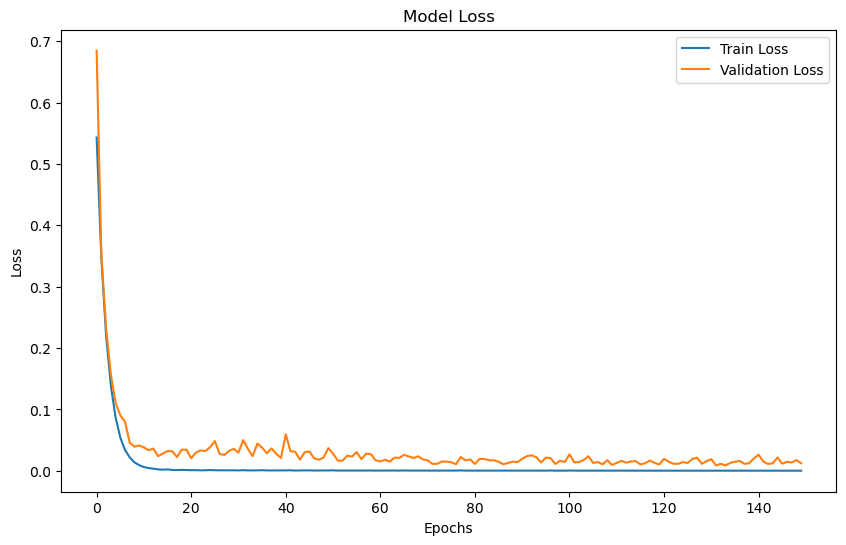

In [21]:
# training & validation loss values as fxn of epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

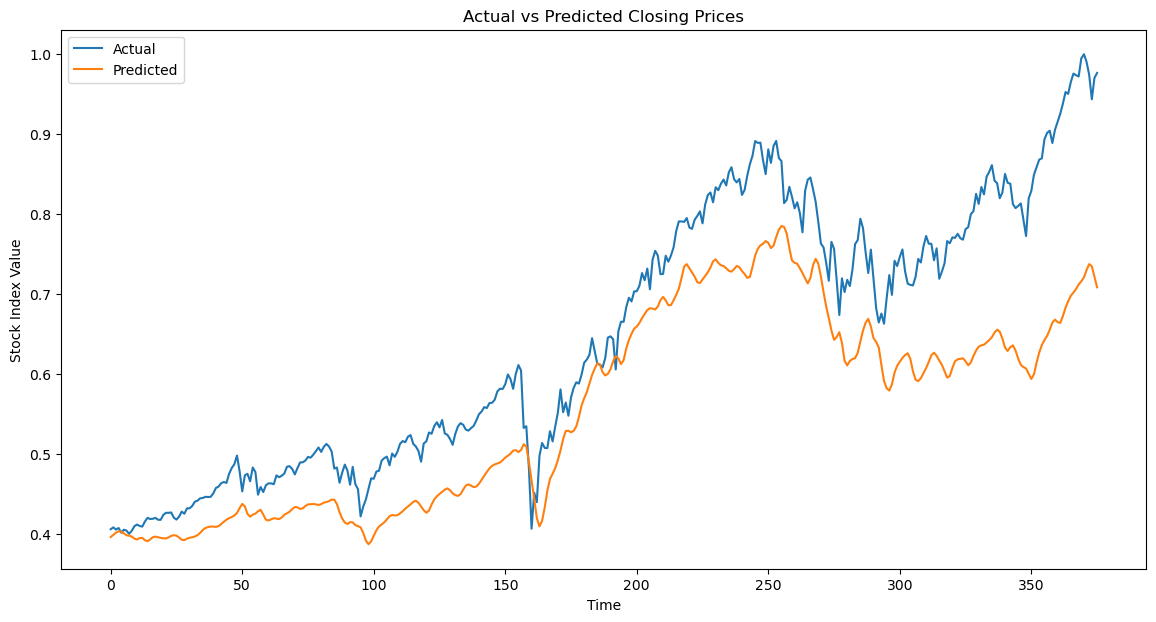

In [24]:
# actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Index Value')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

## Cross-validating

We find that our MAPE metric was inordinately high and use k-fold cross-validation to check for overfitting.

In [23]:
from sklearn.model_selection import TimeSeriesSplit

# k-fold
tscv = TimeSeriesSplit(n_splits=5)
cross_val_results = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # train
    model.fit(X_train_cv, y_train_cv, epochs=150, validation_data=(X_test_cv, y_test_cv), verbose=0)

    # predict
    test_predictions_cv = model.predict(X_test_cv)
    
    # evaluate
    mse_cv = mean_squared_error(y_test_cv, test_predictions_cv)
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = mean_absolute_error(y_test_cv, test_predictions_cv)
    mape_cv = mean_absolute_percentage_error(y_test_cv, test_predictions_cv)
    r2_cv = r2_score(y_test_cv, test_predictions_cv)
    
    cross_val_results.append((mse_cv, rmse_cv, mae_cv, mape_cv, r2_cv))

# avg metrics
avg_cross_val_results = np.mean(cross_val_results, axis=0)
print(f'Cross-Validation MSE: {avg_cross_val_results[0]}')
print(f'Cross-Validation RMSE: {avg_cross_val_results[1]}')
print(f'Cross-Validation MAE: {avg_cross_val_results[2]}')
print(f'Cross-Validation MAPE: {avg_cross_val_results[3]}')
print(f'Cross-Validation R2: {avg_cross_val_results[4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Cross-Validation MSE: 0.0031366659107432875
Cross-Validation RMSE: 0.05071521608423809
Cross-Validation MAE: 0.04062704696494775
Cross-Validation MAPE: 0.2194630815090171
Cross-Validation R2: -0.2317242252245469
